In [2]:
import xarray
import numpy as np
import pandas as pd
import matplotlib as mpl
import torch

import matplotlib.pyplot as plt  # plotting library
import plotly.graph_objects as go

# Issue: Maybe downgrade shapely pip install shapely==1.8.5
import cartopy.crs as ccrs  # Projections list
import cartopy.feature as cfeature # for coastlines

torch.set_printoptions(sci_mode = False)
np.set_printoptions(suppress = True)

# Load COST-G data

- **Temporal coverage**: mid-month 2002-04 to mid-month 2023-11 (21.6 common years)
- **Normalisation period**: 2002-04 to 2020-03 (what is considered zero) (see "Attributes" > "Summary"). However I found that some pattern remains.
- **dm (delta mass) units**: in mm water equivalent i.e. kg/m^2, grid cell area is provided (in m^2) to convert to mass.
- **Relative notion of mass balance**: Gravity is measured as reletive to a long term average. We can take difference to have monthly changes and to build a temporal model.
- **Release**: RL01
- **Citation**:   Sasgen, I., Groh, A., Horwath, M. (2020):
  COST-G GravIS RL01 Ice-Mass Change Products.
  V. 0003. GFZ Data Services. http://doi.org/10.5880/COST-G.GRAVIS_01_L3_ICE

  I get - 115 Gt per year with a linear trend. 

In [3]:
# costg is until 2023
# gmb = xarray.open_dataset(
#    "/home/kim/mass_balance_ConvNP/data/GRACE_COST-G/GRAVIS-3_2002095-2023334_COSTG_0100_AIS_GRID_TUD_0003.nc")

gmb = xarray.open_dataset(
    "/home/kim/new_massbalance/mass_balance_ConvNP/data/GRACE_GFZ/GRAVIS-3_2002095-2023334_COSTG_0100_AIS_GRID_TUD_0003.nc")

# need full path because file is in archive
print(gmb.dm.values.shape)
# shape is same of the order in data variable

(227, 97, 117)


In [4]:
"""
# MRE (minimal reproducible example)
# Load the data
gmb = xarray.open_dataset(
    "/home/kim/new_massbalance/mass_balance_ConvNP/data/GRACE_GFZ/GRAVIS-3_2002095-2023334_COSTG_0100_AIS_GRID_TUD_0003.nc")

# Convert to kg my multiplying by m^2, convert to gt by dividing by 1e12
gmb_gt_xda = (gmb.area * gmb.dm)/1e12

# Sum for first and last time step to get the net mass change
print(gmb_gt_xda[:, :, 0].sum().item()) # prints 697.5245710707866
print(gmb_gt_xda[:, :, -1].sum().item()) # prints -1441.642081441449
"""

'\n# MRE (minimal reproducible example)\n# Load the data\ngmb = xarray.open_dataset(\n    "/home/kim/new_massbalance/mass_balance_ConvNP/data/GRACE_GFZ/GRAVIS-3_2002095-2023334_COSTG_0100_AIS_GRID_TUD_0003.nc")\n\n# Convert to kg my multiplying by m^2, convert to gt by dividing by 1e12\ngmb_gt_xda = (gmb.area * gmb.dm)/1e12\n\n# Sum for first and last time step to get the net mass change\nprint(gmb_gt_xda[:, :, 0].sum().item()) # prints 697.5245710707866\nprint(gmb_gt_xda[:, :, -1].sum().item()) # prints -1441.642081441449\n'

In [5]:
gmb

<xarray.Dataset>
Dimensions:   (x: 117, y: 97, time: 227)
Coordinates:
  * x         (x) float64 -2.9e+06 -2.85e+06 -2.8e+06 ... 2.85e+06 2.9e+06
  * y         (y) float64 -2.4e+06 -2.35e+06 -2.3e+06 ... 2.35e+06 2.4e+06
  * time      (time) datetime64[ns] 2002-04-18 2002-05-10 ... 2023-11-16
Data variables:
    time_dec  (time) float64 ...
    lon       (y, x) float64 ...
    lat       (y, x) float64 ...
    dm        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    area      (y, x) float64 ...
    crs       |S1 ...
Attributes: (12/16)
    title:                Gridded AIS Mass Changes
    institution:          TU Dresden, Chair of Geodetic Earth System Research
    authors:              Andreas Groh, Martin Horwath, Thorben Döhne
    project:              GravIS GRACE/GRACE-FO Level-3 Products
    source:               Monthly COST-G RL01 GRACE/GRACE-FO Level-2B product...
    summary:              GRACE/GRACE-FO derived time series of gridded Antar...
    ...                   ...
    product_version:      0003
    doi:                  10.5880/COST-G.GRAVIS_01_L3_ICE
    netCDF_version:       netCDF-4_classic
    conventions:          CF-1.6
    date_created:         2024-04-05
    contact:              thorben.doehne@tu-dresden.de

## Investigate normalisation period

Should be approximately zero over this period. Email from Thorben Doehne explained why it is only approximately zero. Note the legend which has min/max of around 8 cm.

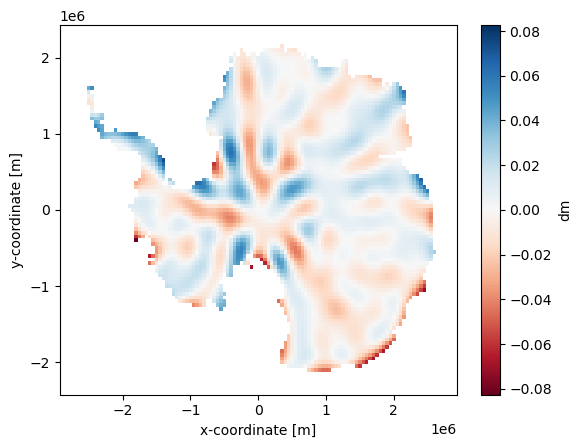

In [6]:
# factor to convert mm w.e. to meters w.e.
mm_to_meters = 0.001

# +1 for indexing
(gmb.dm[0:182+1].mean(dim = 'time') * mm_to_meters).plot(cmap = 'RdBu')

## Center of normalising period

Note the legend has only small values

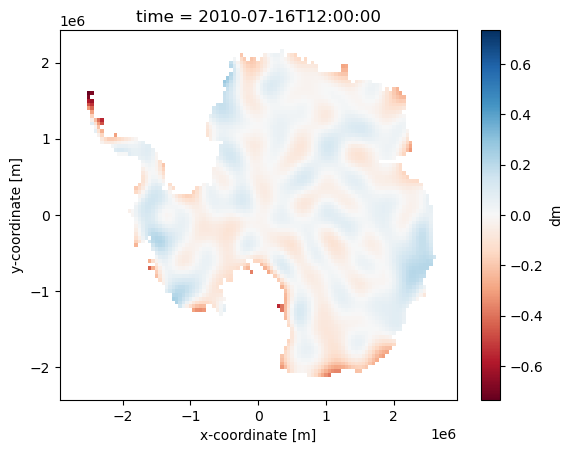

In [7]:
# In the middle of the normalisation period it is also close to zero
(gmb.dm[96] * mm_to_meters).plot(cmap = 'RdBu')

## First observation

Mass was higher relative to long-term averge.

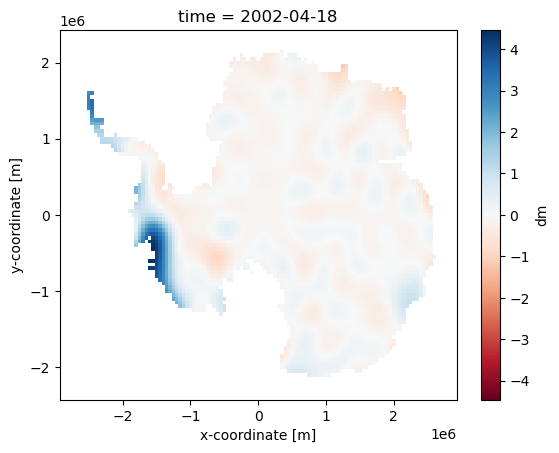

In [8]:
# In the middle of the normalisation period it is also close to zero
(gmb.dm[0] * mm_to_meters).plot(cmap = 'RdBu')

## Last observation

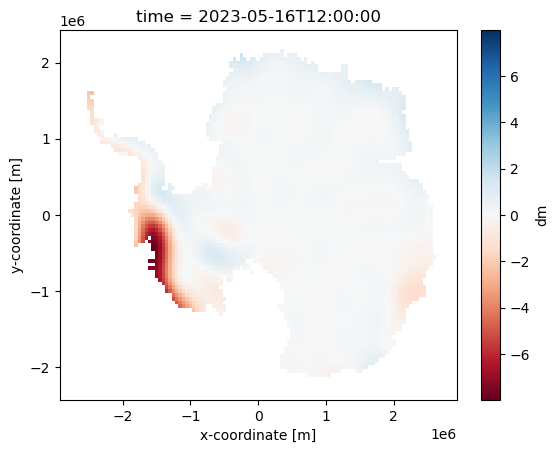

In [9]:
# In the middle of the normalisation period it is also close to zero
(gmb.dm[220] * mm_to_meters).plot(cmap = 'RdBu')

# Convert mm to meters

mm water equivalent: A 1 mm thickness of water over 1 square meter corresponds to a volume of 1 liter (since 1 mm = 1/1000 meters, and multiplying this by 1 m² gives 0.001 m³, which is 1 liter).
kg/m²: Since the density of water is 1000 kg/m³, 1 liter of water has a mass of 1 kilogram.
Thus, 1 mm of water equivalent is equal to 1 kg/m².

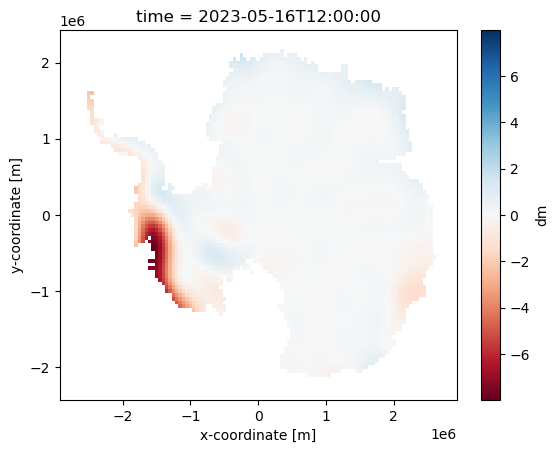

In [10]:
time_index_example = 220
# 162 is an anomaly
gmb_meters = gmb.dm[time_index_example] * mm_to_meters

# xarray plotting function, define cmap so that "melting" is red and "gaining" is blue
gmb_meters.plot(cmap = 'RdBu')
# gmb_meters.plot.hist()

# Export pandas time slices for experiment

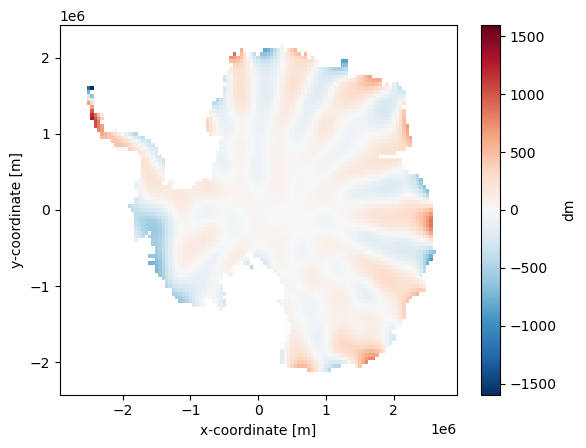

In [11]:
time_index_2023 = 220
time_index_2022 = 220-12

gmb_tensor_2023 = torch.tensor((gmb.dm[time_index_2023]-gmb.dm[time_index_2023-1]).values)
gmb_tensor_2022 = torch.tensor((gmb.dm[time_index_2022]-gmb.dm[time_index_2022-1]).values)

# Differnece between 2023 and 2022 (not so similar -> low task correlation)
(gmb.dm[time_index_2023] - gmb.dm[time_index_2022]).plot()

# Make mesh once
xx, yy = np.meshgrid(gmb.dm.x, gmb.dm.y)

gmb_gravis_2023_04to05 = torch.stack((gmb_tensor_2023, torch.tensor(xx), torch.tensor(yy)), dim = 2)
gmb_gravis_2022_04to05 = torch.stack((gmb_tensor_2022, torch.tensor(xx), torch.tensor(yy)), dim = 2)

torch.save(gmb_gravis_2023_04to05, "/home/kim/new_massbalance/mass_balance_ConvNP/data/GRACE_GFZ/gmb_gravis_2023_04to05.pt")
torch.save(gmb_gravis_2022_04to05, "/home/kim/new_massbalance/mass_balance_ConvNP/data/GRACE_GFZ/gmb_gravis_2022_04to05.pt")

In [12]:
# Visualise with plt imshow
# plt.imshow(gmb.dm.values[3], origin = "lower", cmap = "RdBu_r")

# Conversion to gt (gigatons) and gt/month

- kg/m^2 == mm. water equivalent (equivalent metrics)
- area is denoted in m^2
- 1 gt is 1 trillion kilograms so 1 x 10^12

## Difference

Units were gt relative to gt at another time. 
- [change in gt per month]

In [13]:
gmb.area.values
gmb.dm.values.shape

# Check with torch elementswise multiplication
# both tensors (97, 117)
torch.mul(torch.tensor(gmb.area.values), torch.tensor(gmb.dm.values[0])).nansum()/1e12
torch.mul(torch.tensor(gmb.area.values), torch.tensor(gmb.dm.values[1])).nansum()/1e12

tensor(820.6307, dtype=torch.float64)

In [14]:
# convert to kg my multiplying by m^2, convert to gt by dividing by 1e12
gmb_gt_xda = (gmb.area * gmb.dm)/1e12

# difference between two months
# reorder dimensions to what we had before
gmb_gt_month_xda = gmb_gt_xda.diff(dim = "time").transpose("time", "y", "x")
# Difference has one value less: starts with 2002-05-10, because 2002-04-10 is the first value
print(gmb_gt_month_xda.shape)

(226, 97, 117)


# Linear fit

In [15]:
# Get x values
nanoseconds = gmb_gt_xda.time.values.astype('int64')
years = nanoseconds / 10**9 / 86400 / 30.44 / 12
x = years - years[0]

# Get y values
y = np.nansum(gmb_gt_xda.values, axis = (0, 1))
# regress to degree 1: bias and slope
m, b = np.polyfit(x = x, y = y, deg = 1)

# Units are years so 
print(m)
print(b) # bias term doesn't really have meaning

-115.59375065836112
976.9082153318411


In [16]:
# 783/697
# 1733/1441

## Investigate outlier

Index 161: 2017-05-16 (second last recording of GRACE)  
Index 162: 2017-06-11 (last recording of GRACE) (observing a surprisingly large amount of ice/gravity.)  
Index 163: 2018-06-16 (first recording of GRACE-FO)

Between 2017-05-16 and 2017-06-11 the AIS has gained 693.61 gt. This is unexpected.
Between 2017-06-11 and 2018-06-16 the AIS has lost -637.35 gt, going back to previous levels.


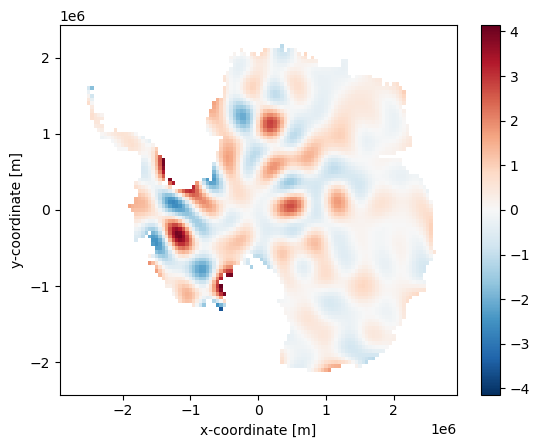

In [17]:
(gmb_gt_xda[:, :, 162] - gmb_gt_xda[:, :, 161]).plot()
print("Between 2017-05-16 and 2017-06-11 the AIS has gained {} gt. This is unexpected.".format(np.round((gmb_gt_xda[:, :, 162] - gmb_gt_xda[:, :, 161]).sum().item(), 2)))

print("Between 2017-06-11 and 2018-06-16 the AIS has lost {} gt, going back to previous levels.".format(np.round((gmb_gt_xda[:, :, 163] - gmb_gt_xda[:, :, 162]).sum().item(), 2)))

In [18]:
# Optional: remove the month after the missing year
# print(gmb_gt_month_xda.shape)
# gmb_gt_validmonths_xda = xarray.concat([gmb_gt_month_xda[0:162], gmb_gt_month_xda[163:]], dim = "time")
# print(gmb_gt_validmonths_xda.shape)

# Comparison

I compare this to the chart on https://gravis.gfz-potsdam.de/ais for GRACE/GRACE-FO COST-G RL01. (Release 01 used, not 03 like us.)

2002-04: 783 gt
2017-05: -1297 gt
(2080 gt lost until then)

2017-06: -576
(721 gt gained in just a month)

2023-11: -1733
(total 2516 gt lost, 116 per year)

In [19]:
# 783+1297
# 1297-576
# (783+1733)/21.6

In [20]:
timeseries_gmb = gmb_gt_xda.sum(dim = ["x", "y"])
timeseries_gmb_zero_at_start = timeseries_gmb - timeseries_gmb[0]

# Last value
print("AIS ice loss per year based on first and last value, in Gt:")
print(np.round((timeseries_gmb_zero_at_start[-1]/21.6).item(), 2))
# Alternative: fit linear trend

fig = go.Figure()

fig.add_trace(go.Scatter(x = timeseries_gmb.time[0:163], 
                         y = timeseries_gmb_zero_at_start[0:163], 
                         mode = 'lines+markers',
                         line = dict(color = 'cornflowerblue'),
                         name = 'GRACE'))

fig.add_trace(go.Scatter(x = timeseries_gmb.time[163:], 
                         y = timeseries_gmb_zero_at_start[163:], 
                         mode = 'lines+markers',
                         line = dict(color = 'navy'),
                         name = 'GRACE-FO'))

fig.update_layout(title = 'AIS mass balance from 2002-4 to 2023-11 (relative to 2002-04) from COST-G GRAVIS GRID RL01',
                   xaxis_title = 'time',
                   yaxis_title = 'mass balance [Gt]')

fig.update_layout(template = "plotly_white")
fig.update_layout(font_family = "Lato")

fig.show()

AIS ice loss per year based on first and last value, in Gt:
-99.04


In [21]:
timeseries_gmb = gmb_gt_xda.sum(dim = ["x", "y"])
timeseries_gmb_zero_at_start = timeseries_gmb - timeseries_gmb[0]

# Last value
print("AIS ice loss per year based on first and last value, in Gt:")
print(np.round((timeseries_gmb_zero_at_start[-1]/21.6).item(), 2))
# Alternative: fit linear trend

fig = go.Figure()

fig.add_trace(go.Scatter(x = timeseries_gmb.time[0:163], 
                         y = timeseries_gmb[0:163], 
                         mode = 'lines+markers',
                         line = dict(color = 'cornflowerblue'),
                         name = 'GRACE'))

fig.add_trace(go.Scatter(x = timeseries_gmb.time[163:], 
                         y = timeseries_gmb[163:], 
                         mode = 'lines+markers',
                         line = dict(color = 'navy'),
                         name = 'GRACE-FO'))

fig.update_layout(title = 'AIS mass balance from 2002-4 to 2023-11 (relative to 2002-04 to 2020-03) from COST-G GRAVIS GRID RL01',
                   xaxis_title = 'time',
                   yaxis_title = 'mass balance [Gt]')

fig.update_layout(template = "plotly_white")
fig.update_layout(font_family = "Lato")

fig.show()

AIS ice loss per year based on first and last value, in Gt:
-99.04


In [22]:
# Differences data
timeseries_gmb_diff = gmb_gt_month_xda.sum(dim = ["x", "y"])
# Outlier is only one crazy datapoint in other data

fig = go.Figure()

fig.add_trace(go.Scatter(x = timeseries_gmb_diff.time[0:162], 
                         y = timeseries_gmb_diff[0:162], 
                         mode = 'lines+markers',
                         line = dict(color = 'cornflowerblue'),
                         name = 'GRACE'))

fig.add_trace(go.Scatter(x = timeseries_gmb_diff.time[162:], 
                         y = timeseries_gmb_diff[162:], 
                         mode = 'lines+markers',
                         line = dict(color = 'navy'),
                         name = 'GRACE-FO'))

fig.update_layout(title = 'Mass balance CHANGE per month (compared to prior month, thus starts 2002-05)',
                   xaxis_title = 'time',
                   yaxis_title = 'mass balance [Gt]')

fig.update_layout(template = "plotly_white")
fig.update_layout(font_family = "Lato")

fig.show()

# Calculate yearly ice loss

In [23]:
# roughly yearly ice loss in Gt (gap in data)
# use all data points including that after the gap (so not valid months)
gmb_gt_month_xda.sum()/((gmb_gt_month_xda.time[0] - gmb_gt_month_xda.time[-1]) / pd.Timedelta('365 days'))

<xarray.DataArray ()>
array(99.33789162)

In [24]:
i = 120

fig = go.Figure(go.Heatmap(
    z = gmb_gt_month_xda[i],
    colorscale = 'RdBu',
    zmid = 0,))

fig.update_layout(
    title = str(gmb_gt_month_xda[i].time)[45:55],
)

fig.update_traces(colorbar_orientation = "v")
fig.update_traces(colorbar_title = "mass balance [gt]")
fig.update_traces(colorbar_len = 0.7)

fig.update_layout(
    height = 800,
    width = 800,
    yaxis_scaleanchor = "x",
)

fig.update_xaxes(visible = False)
fig.update_yaxes(visible = False)

fig.update_layout(template = "plotly_white")
fig.update_layout(font_family = "Lato")
# fig.update_layout(font_family = "Open Sans")

fig.show()

In [25]:
fig = go.Figure(go.Heatmap(
    # mean or sum
    z = gmb_gt_month_xda.mean(dim = "time"),
    colorscale = 'RdBu',
    zmid = 0,))

fig.update_layout(
    title = "Mean mass balance change over all months",
)

fig.update_traces(colorbar_orientation = "v")
fig.update_traces(colorbar_title = "mass balance [gt]")
fig.update_traces(colorbar_len = 0.7)

fig.update_layout(
    height = 800,
    width = 800,
    yaxis_scaleanchor = "x",
)

fig.update_xaxes(visible = False)
fig.update_yaxes(visible = False)

fig.update_layout(template = "plotly_white")
fig.update_layout(font_family = "Lato")
# fig.update_layout(font_family = "Open Sans")

fig.show()

In [26]:
fig = go.Figure(go.Heatmap(
    # mean or sum
    z = gmb_gt_month_xda.sum(dim = "time"),
    colorscale = 'RdBu',
    zmid = 0,))

fig.update_layout(
    title = "Mean mass balance change over all months",
)

fig.update_traces(colorbar_orientation = "v")
fig.update_traces(colorbar_title = "mass balance [gt]")
fig.update_traces(colorbar_len = 0.7)

fig.update_layout(
    height = 800,
    width = 800,
    yaxis_scaleanchor = "x",
)

fig.update_xaxes(visible = False)
fig.update_yaxes(visible = False)

fig.update_layout(template = "plotly_white")
fig.update_layout(font_family = "Lato")
# fig.update_layout(font_family = "Open Sans")

fig.show()

# Align with ICESat data

- beginning 2003 to end of 2018
- meters w.e. (given in kg/m^2)
- per year

In [34]:
gmb_gt_month_xda[5] # 2002-12
gmb_gt_month_xda[166]

<xarray.DataArray (y: 97, x: 117)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 -2.9e+06 -2.85e+06 -2.8e+06 ... 2.85e+06 2.9e+06
  * y        (y) float64 -2.4e+06 -2.35e+06 -2.3e+06 ... 2.35e+06 2.4e+06
    time     datetime64[ns] 2018-12-16T12:00:00

In [48]:
gmb_comparison = (gmb.dm[166] - gmb.dm[5]) * mm_to_meters

In [64]:
# rough check: -104 gt per year
np.sum((gmb.area * (gmb.dm[166] - gmb.dm[5]))/1e12/16)

# YEARLY mass balance in meters w.e.
gmb_comparison = (gmb.dm[166] - gmb.dm[5]) * mm_to_meters / 16

print(np.nanmax(gmb_comparison))
print(np.nanmin(gmb_comparison))
print(np.nanmean(gmb_comparison))
print(np.nansum(gmb_comparison))

0.11015625
-0.5908125
-0.008486606960343418
-41.516481250000005


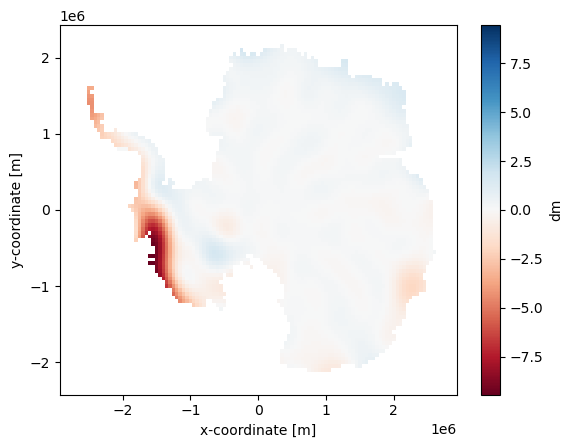

In [46]:
((gmb.dm[166] - gmb.dm[5])* mm_to_meters).plot(cmap = "RdBu")

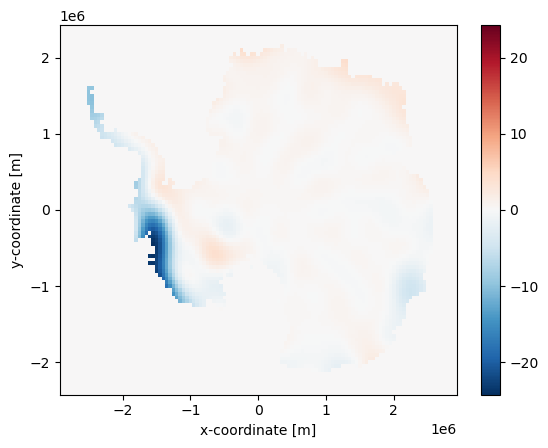

In [37]:
gmb_gt_month_xda[5:166+1].sum(dim = "time").plot()

In [88]:
# 143 values
gmb_tensor_12years = torch.tensor(gmb_gt_month_xda[0:142+1].sum(dim = "time").values)

# Make mesh once
xx, yy = np.meshgrid(gmb.dm.x, gmb.dm.y)

gmb_costg_12years = torch.stack((gmb_tensor_12years, torch.tensor(xx), torch.tensor(yy)), dim = 2)

torch.save(gmb_costg_12years, "/home/kim/new_massbalance/mass_balance_ConvNP/data/GRACE_GFZ/gmb_costg_12years.pt")

In [81]:
fig = go.Figure(go.Heatmap(
    # mean or sum
    z = gmb_gt_month_xda[0:142+1].sum(dim = "time"),
    colorscale = 'RdBu',
    zmid = 0,))

fig.update_layout(
    title = "Mean mass balance change over all months",
)

fig.update_traces(colorbar_orientation = "v")
fig.update_traces(colorbar_title = "mass balance [gt]")
fig.update_traces(colorbar_len = 0.7)

fig.update_layout(
    height = 800,
    width = 800,
    yaxis_scaleanchor = "x",
)

fig.update_xaxes(visible = False)
fig.update_yaxes(visible = False)

fig.update_layout(template = "plotly_white")
fig.update_layout(font_family = "Lato")
# fig.update_layout(font_family = "Open Sans")

fig.show()

In [82]:
gmb_gt_month_xda[0:142+1]

<xarray.DataArray (time: 143, y: 97, x: 117)> Size: 13MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x        (x) float64 936B -2.9e+06 -2.85e+06 -2.8e+06 ... 2.85e+06 2.9e+06
  * y        (y) float64 776B -2.4e+06 -2.35e+06 -2.3e+06 ... 2.35e+06 2.4e+06
  * time     (time) datetime64[ns] 1kB 2002-05-10 ... 2015-04-16

# Export

In [ ]:
# reorder dimensions to what we had before
# gmb_gt_validmonths_xda = gmb_gt_validmonths_xda[["time", "y", "x"]]

In [ ]:
gmb_gt_validmonths_xda.to_netcdf(path = "data/GRACE_COST-G/gmb_gt_validmonths_xda.nc")

# Other display

- non-stationary trend: change relative to the first time slice
- near-stationary (with seasonal trend): change relative to the previous time slice

In [ ]:
# Upper: time of upper bound
gmb_month = gmb.dm.diff(dim = "time")
gmb_month.mean()

In [ ]:
i = 110
plt.imshow(gmb_month[i], origin = "lower")

In [ ]:
# Difference between month 1 and month 0
# np.nanmin(gmb.dm.values[1] - gmb.dm.values[0])
# Mass gain
np.nansum(gmb.dm.values[1] - gmb.dm.values[0])

In [ ]:
n = 183
# gap in time between Grace and Grace FO
np.nansum(gmb.dm.values[n + 1] - gmb.dm.values[n])

In [ ]:
n = 195
np.nansum(gmb.dm.values[n + 1] - gmb.dm.values[n])

# Examine basin-level data

Only gridded data were supplied and server access still does not work. 